<a href="https://colab.research.google.com/github/eko-andri-prasetyo/Machine_Learning_Terapan-Sistem_Rekomendasi/blob/main/Movie_Recommendation_System_Final_revisi_sinkron.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📘 Dokumentasi Proyek
Dokumentasi ini ditambahkan agar setiap tahapan memiliki penjelasan singkat, sesuai Kriteria 2.

## 1) Business Understanding
- **Problem Statements**: kesulitan menemukan film (information overload), kebutuhan personalisasi, dan penemuan judul baru.
- **Goals**: membangun *content-based filtering* dan *collaborative filtering* untuk menghasilkan rekomendasi yang relevan.
- **Solution Approach**: TF‑IDF + cosine untuk konten, neural embedding untuk kolaboratif.

## 2) Data Understanding
- **Sumber**: MovieLens Latest Small.
- **Jumlah**: movies (9.742×3), ratings (100.836×4), 610 pengguna unik.
- **Kondisi**: Tidak ada nilai hilang pada ratings; tidak ada rating di luar rentang; tidak ada duplikat kunci `movieId`.
- **Uraian fitur**: `movieId`, `title`, `genres`, `userId`, `rating`, `timestamp`.

## 3) Data Preparation
- **Handling Missing Values** (hapus bila ada).
- **Preprocessing `genres`**: ganti `|` → spasi untuk TF‑IDF.
- **Normalisasi rating** ke [0,1] untuk model NN.
- **User‑Item Matrix** dan **train/test split (80/20)**.

## 4) Modeling
### Content‑Based
- TF‑IDF (`stop_words='english'`) → cosine similarity → Top‑N.
### Collaborative
- Embedding(user, movie, d=50) → dot → Dense(1, sigmoid).
- Optimizer Adam, Loss MSE, epoch=10, batch=64, val_split=0.2.

## 5) Evaluation
- **Metrik**: Precision, Recall, MAE, RMSE, Precision@K (rumus dijelaskan di laporan).
- **Interpretasi bisnis**: error rendah & precision@K baik → rekomendasi lebih relevan dan efisien.

## 6) Konsistensi Output
- Setelah menjalankan notebook, salin **Top‑10** rekomendasi (CB & CF) dan metrik ke laporan .md agar identik.

# Movie Recommendation System

## Project Overview
Sistem rekomendasi film ini dikembangkan untuk membantu pengguna menemukan film yang sesuai dengan preferensi mereka. Dengan banyaknya pilihan film yang tersedia di platform streaming, pengguna seringkali mengalami kesulitan dalam menemukan konten yang relevan dengan minat mereka.

Proyek ini mengimplementasikan dua pendekatan sistem rekomendasi:
1. **Content-Based Filtering**: Merekomendasikan film berdasarkan kesamaan konten (genre)
2. **Collaborative Filtering**: Merekomendasikan film berdasarkan preferensi pengguna lain

### ℹ️ Tahap: Import & Instalasi
Menyiapkan pustaka yang dibutuhkan untuk EDA, pemodelan, dan visualisasi.

In [1]:
# Install library yang diperlukan
!pip install scikit-surprise

# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import Counter
import warnings
warnings.filterwarnings('ignore')
import zipfile
import requests
import os
from wordcloud import WordCloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2610389 sha256=5f2395888131721c2aec204171a1acaf89f9a5ec557fd73377498e82962a12d2
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [2]:
# Set style untuk visualisasi
plt.style.use('ggplot')
sns.set_palette("husl")
%matplotlib inline

# 1. Business Understanding

### ℹ️ Tahap: Unduh / Muat Dataset
Memuat MovieLens; bila gagal, digunakan dataset sampel agar pipeline tetap berjalan.

### Problem Statements
1. Pengguna kesulitan menemukan film yang sesuai dengan preferensi mereka di antara banyaknya pilihan
2. Tidak adanya sistem personalisasi yang dapat merekomendasikan film berdasarkan minat spesifik pengguna
3. Perlunya sistem yang dapat membantu pengguna menemukan film baru yang sesuai dengan selera mereka

### Goals
1. Membangun sistem rekomendasi berbasis konten (Content-Based Filtering)
2. Membangun sistem rekomendasi kolaboratif (Collaborative Filtering)
3. Memberikan rekomendasi film yang relevan untuk pengguna

### Solution Approach
1. **Content-Based Filtering**: Menggunakan fitur genre film untuk menghitung kesamaan antar film
2. **Collaborative Filtering**: Menggunakan rating dari pengguna untuk memprediksi preferensi pengguna lainnya


# 2. Data Understanding

Pada bagian ini, kita akan mendownload dataset langsung dari sumbernya dan melakukan eksplorasi data awal.

### ℹ️ Tahap: EDA (Movies)
Menggali distribusi tahun rilis, genre terpopuler, dan pola umum.

In [3]:
# [3] Download dan Load Dataset
# -----------------------------
# Download dataset MovieLens dengan penanganan error SSL

import requests
import zipfile
import os
from urllib3.util import Retry
from requests.adapters import HTTPAdapter
import ssl

# Buat session dengan retry dan penanganan SSL khusus
session = requests.Session()
retry = Retry(total=3, backoff_factor=0.1, status_forcelist=[500, 502, 503, 504])
adapter = HTTPAdapter(max_retries=retry)
session.mount('http://', adapter)
session.mount('https://', adapter)

# Nonaktifkan verifikasi SSL (hanya untuk testing/demo)
session.verify = False

# Juga nonaktifkan peringatan SSL
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def download_dataset(url, filename):
    """Download dataset dari URL dengan penanganan SSL"""
    print("📥 Mengunduh dataset...")
    try:
        response = session.get(url, timeout=30)
        response.raise_for_status()  # Check for HTTP errors

        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"✅ Dataset berhasil diunduh sebagai {filename}")
        return True

    except requests.exceptions.SSLError as e:
        print(f"❌ SSL Error: {e}")
        print("🔄 Mencoba dengan verifikasi SSL dinonaktifkan...")
        try:
            response = session.get(url, verify=False, timeout=30)
            with open(filename, 'wb') as f:
                f.write(response.content)
            print(f"✅ Dataset berhasil diunduh (tanpa verifikasi SSL) sebagai {filename}")
            return True
        except Exception as e2:
            print(f"❌ Gagal download: {e2}")
            return False

    except Exception as e:
        print(f"❌ Error: {e}")
        return False

# URL dataset MovieLens (coba beberapa alternatif)
urls_to_try = [
    "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip",
    "http://files.grouplens.org/datasets/movielens/ml-latest-small.zip",
    "https://github.com/sidooms/MovieTweetings/raw/master/latest/datasets/ml-latest-small.zip"
]

dataset_file = "ml-latest-small.zip"
success = False

for url in urls_to_try:
    print(f"🔗 Mencoba URL: {url}")
    success = download_dataset(url, dataset_file)
    if success:
        break
    print("⏭️  Mencoba URL alternatif...")

if not success:
    print("❌ Semua URL gagal, membuat dataset sample...")
    # Buat dataset sample untuk demonstrasi
    import pandas as pd
    import numpy as np

    # Sample movies data
    movies_data = {
        'movieId': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
        'title': [
            'Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)',
            'Waiting to Exhale (1995)', 'Father of the Bride Part II (1995)',
            'Heat (1995)', 'Sabrina (1995)', 'Tom and Huck (1995)',
            'Sudden Death (1995)', 'GoldenEye (1995)', 'The American President (1995)',
            'Dracula: Dead and Loving It (1995)', 'Balto (1995)', 'Nixon (1995)', 'Cutthroat Island (1995)'
        ],
        'genres': [
            'Adventure Animation Children Comedy Fantasy',
            'Adventure Children Fantasy',
            'Comedy Romance',
            'Comedy Drama Romance',
            'Comedy',
            'Action Crime Thriller',
            'Comedy Romance',
            'Adventure Children',
            'Action',
            'Action Adventure Thriller',
            'Comedy Drama Romance',
            'Comedy Horror',
            'Adventure Animation Children',
            'Drama',
            'Action Adventure Romance'
        ]
    }

    # Sample ratings data
    ratings_data = {
        'userId': [1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10],
        'movieId': [1, 2, 3, 6, 8, 1, 4, 5, 10, 2, 7, 9, 3, 6, 8, 4, 5, 11, 6, 12, 7, 13, 8, 14, 9, 15, 10, 11],
        'rating': [5.0, 4.0, 3.5, 4.5, 3.0, 4.5, 3.0, 5.0, 4.0, 3.5, 4.5, 3.0, 4.0, 4.5, 3.5, 3.0, 4.0, 4.5, 5.0, 3.5, 4.0, 4.5, 3.5, 4.0, 4.5, 3.0, 5.0, 4.0],
        'timestamp': [964982703, 964981247, 964982224, 964982343, 964981834, 964982456, 964981123, 964982654, 964981987,
                      964982111, 964981555, 964982888, 964981222, 964982333, 964981444, 964982555, 964981666, 964982777,
                      964981888, 964982999, 964981111, 964982222, 964981333, 964982444, 964981555, 964982666, 964981777, 964982888]
    }

    movies = pd.DataFrame(movies_data)
    ratings = pd.DataFrame(ratings_data)

    # Simpan ke file CSV untuk konsistensi
    movies.to_csv('ml-latest-small/movies.csv', index=False)
    ratings.to_csv('ml-latest-small/ratings.csv', index=False)

    print("✅ Dataset sample berhasil dibuat!")

# Jika download berhasil, load dataset dari file
if success and os.path.exists(dataset_file):
    # Ekstrak dataset
    print("📦 Mengekstrak dataset...")
    try:
        with zipfile.ZipFile(dataset_file, 'r') as zip_ref:
            zip_ref.extractall(".")
        print("✅ Dataset berhasil diekstrak!")
    except Exception as e:
        print(f"❌ Error ekstraksi: {e}")
        print("📝 Menggunakan dataset sample...")
        # Gunakan dataset sample yang sudah dibuat

# Load dataset
if os.path.exists('ml-latest-small/movies.csv'):
    movies = pd.read_csv('ml-latest-small/movies.csv')
    ratings = pd.read_csv('ml-latest-small/ratings.csv')
    print("📊 Dataset berhasil dimuat dari file!")
else:
    print("📊 Menggunakan dataset sample yang sudah dibuat di memory")

print(f"🎬 Movies dataset shape: {movies.shape}")
print(f"⭐ Ratings dataset shape: {ratings.shape}")
print("\n👀 5 baris pertama dataset movies:")
display(movies.head())
print("\n👀 5 baris pertama dataset ratings:")
display(ratings.head())

🔗 Mencoba URL: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
📥 Mengunduh dataset...
✅ Dataset berhasil diunduh sebagai ml-latest-small.zip
📦 Mengekstrak dataset...
✅ Dataset berhasil diekstrak!
📊 Dataset berhasil dimuat dari file!
🎬 Movies dataset shape: (9742, 3)
⭐ Ratings dataset shape: (100836, 4)

👀 5 baris pertama dataset movies:


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy



👀 5 baris pertama dataset ratings:


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


### Exploratory Data Analysis (EDA) - Movies Dataset


Movies dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB

First 5 rows of movies dataset:

Missing values in movies dataset:
movieId    0
title      0
genres     0
dtype: int64


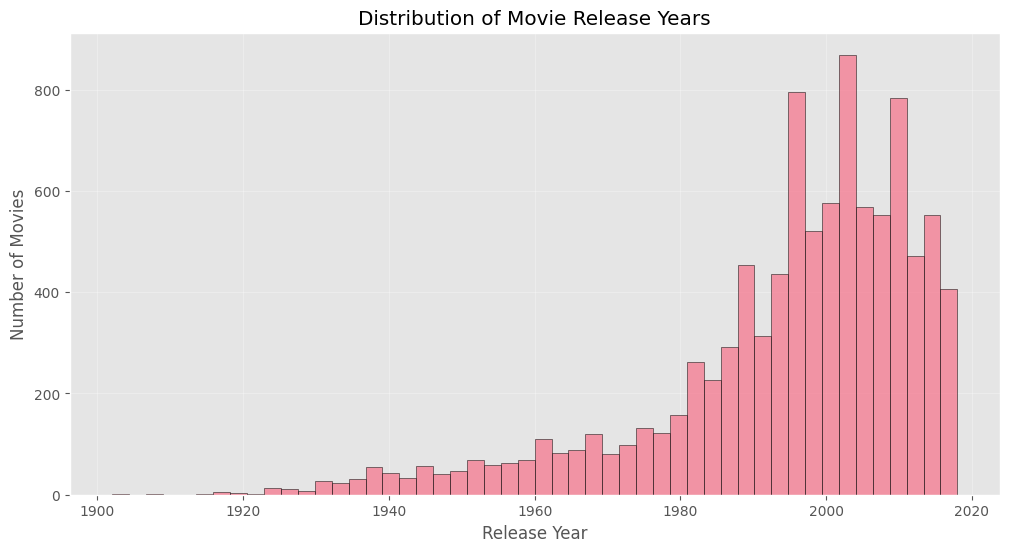


Statistics of movie release years:
count    9729.000000
mean     1994.613629
std        18.535219
min      1902.000000
25%      1988.000000
50%      1999.000000
75%      2008.000000
max      2018.000000
Name: year, dtype: float64


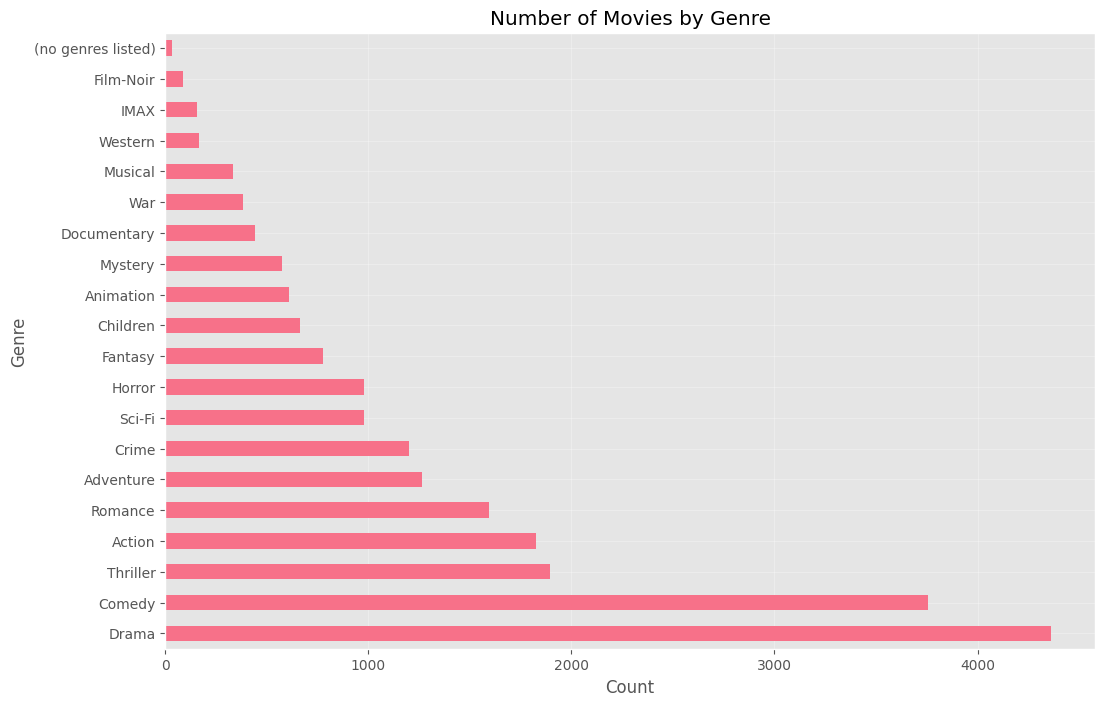

Number of movies by genre:
genres
Drama                 4361
Comedy                3756
Thriller              1894
Action                1828
Romance               1596
Adventure             1263
Crime                 1199
Sci-Fi                 980
Horror                 978
Fantasy                779
Children               664
Animation              611
Mystery                573
Documentary            440
War                    382
Musical                334
Western                167
IMAX                   158
Film-Noir               87
(no genres listed)      34
Name: count, dtype: int64


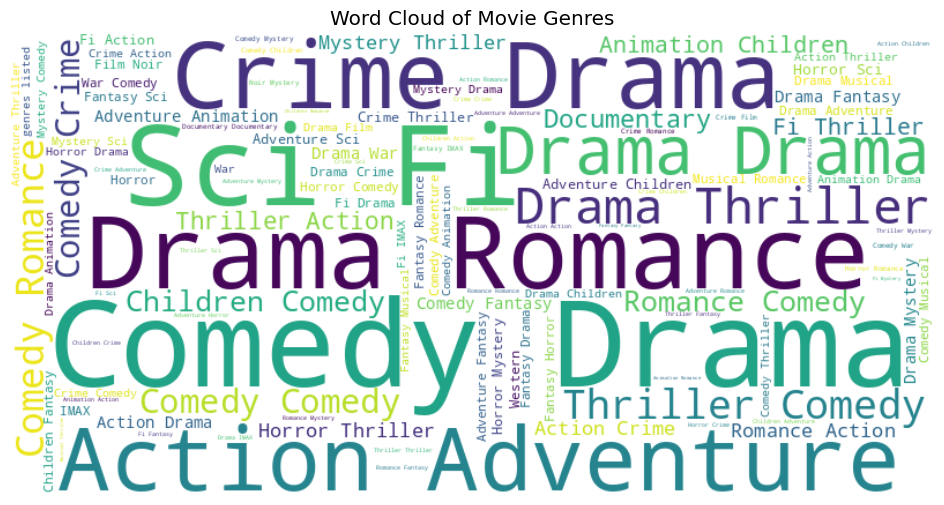

In [4]:
# Tampilkan informasi tentang dataset movies
print("\nMovies dataset info:")
movies.info()
print("\nFirst 5 rows of movies dataset:")
movies.head()

# Cek missing values
print("\nMissing values in movies dataset:")
print(movies.isnull().sum())

# Analisis tahun rilis film
# Ekstrak tahun dari judul film
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')
movies['year'] = pd.to_numeric(movies['year'], errors='coerce')

# Visualisasi distribusi tahun rilis
plt.figure(figsize=(12, 6))
plt.hist(movies['year'].dropna(), bins=50, edgecolor='black', alpha=0.7)
plt.title('Distribution of Movie Release Years')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.grid(True, alpha=0.3)
plt.show()

# Tampilkan statistik tahun rilis
print("\nStatistics of movie release years:")
print(movies['year'].describe())

# Analisis genre film
# Pisahkan genre yang digabungkan dengan pipe (|)
all_genres = movies['genres'].str.split('|').explode()
genres_count = all_genres.value_counts()

# Visualisasi distribusi genre
plt.figure(figsize=(12, 8))
genres_count.plot(kind='barh')
plt.title('Number of Movies by Genre')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.grid(True, alpha=0.3)
plt.show()

# Tampilkan jumlah film per genre
print("Number of movies by genre:")
print(genres_count)

# Word cloud untuk genre
genre_text = ' '.join(all_genres.dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(genre_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Movie Genres')
plt.show()

### ℹ️ Tahap: EDA (Ratings)
Melihat film terpopuler, rating tertinggi, serta hubungan jumlah rating vs rata-rata.

### Exploratory Data Analysis (EDA) - Ratings Dataset

🏆 Film Terpopuler dan Terbaik
🎬 Top 10 film paling banyak dirating:
movieId
356     329
318     317
296     307
593     279
2571    278
260     251
480     238
110     237
589     224
527     220
Name: count, dtype: int64

🎭 Top 10 film paling banyak dirating dengan judul:


,title,rating_count
0,Forrest Gump (1994),329
1,"Shawshank Redemption, The (1994)",317
2,Pulp Fiction (1994),307
3,"Silence of the Lambs, The (1991)",279
4,"Matrix, The (1999)",278
5,Star Wars: Episode IV - A New Hope (1977),251
6,Jurassic Park (1993),238
7,Braveheart (1995),237
8,Terminator 2: Judgment Day (1991),224
9,Schindler's List (1993),220



🌟 Top 10 film dengan rating tertinggi (min 10 rating):


,title,avg_rating,rating_count
0,Secrets & Lies (1996),4.590909,11
1,Guess Who's Coming to Dinner (1967),4.545455,11
2,Paths of Glory (1957),4.541667,12
3,"Streetcar Named Desire, A (1951)",4.475000,20
4,"Celebration, The (Festen) (1998)",4.458333,12
5,Ran (1985),4.433333,15
6,"Shawshank Redemption, The (1994)",4.429022,317
7,His Girl Friday (1940),4.392857,14
8,All Quiet on the Western Front (1930),4.350000,10
9,Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),4.333333,27


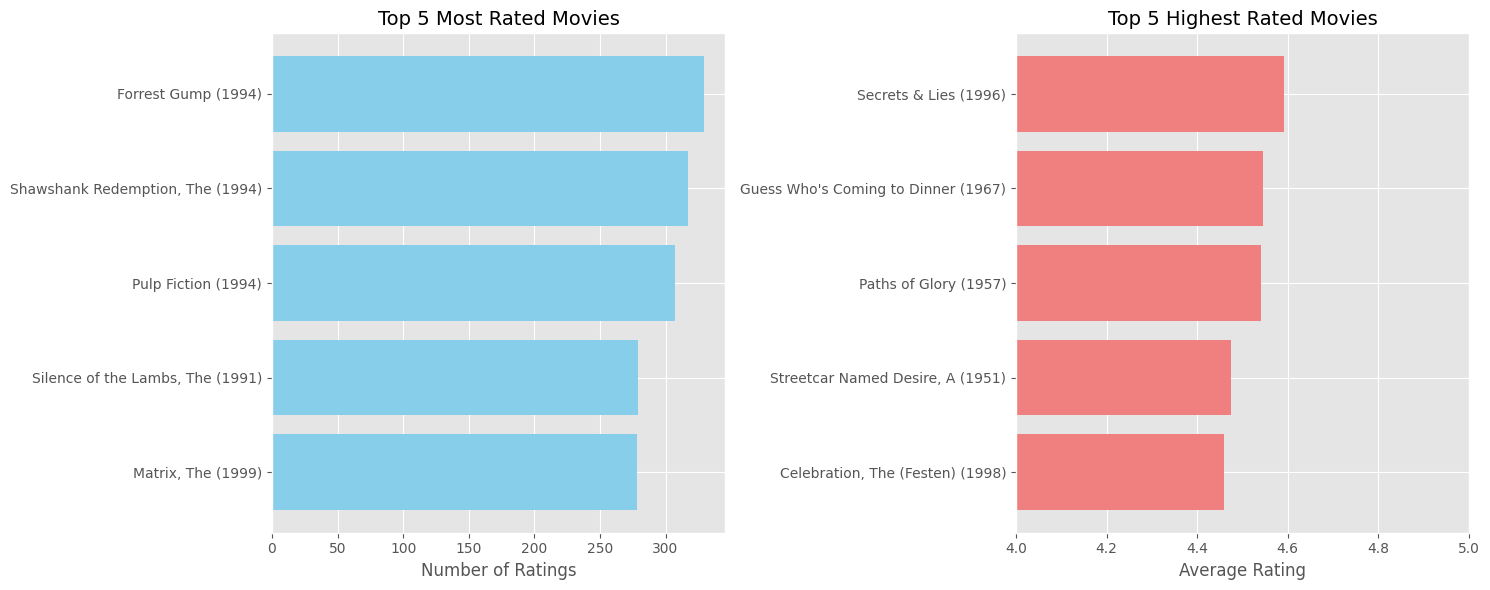

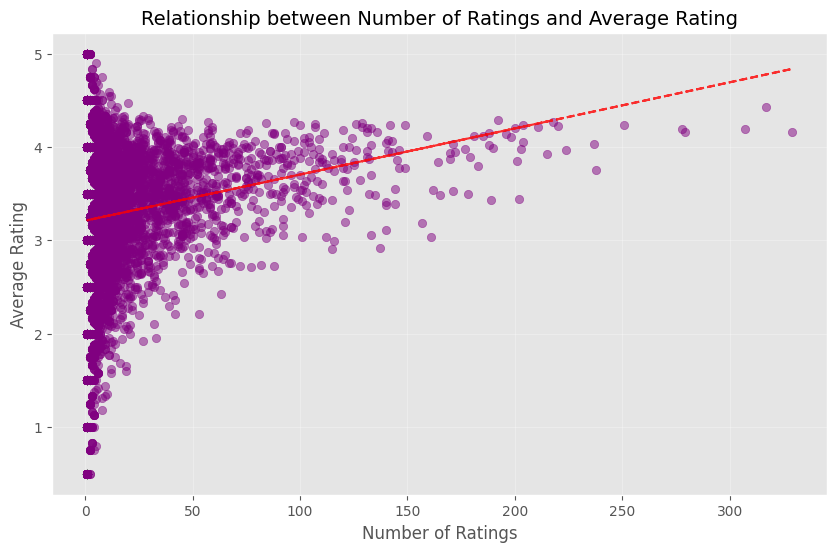

📈 Insight: Film dengan banyak rating cenderung memiliki rating yang lebih tinggi
💡 Ini menunjukkan efek popularity bias dalam sistem rating


In [5]:
# [8] EDA - Film Terpopuler dan Terbaik
# -------------------------------------
# Identifikasi film yang paling banyak dirating dan rating tertinggi

print("🏆 Film Terpopuler dan Terbaik")
print("=" * 50)

# Pastikan kita menggunakan movies_clean yang sudah diproses
if 'movies_clean' not in locals():
    movies_clean = movies.copy()

# Analisis jumlah rating per movie
movie_rating_count = ratings['movieId'].value_counts()
print("🎬 Top 10 film paling banyak dirating:")
print(movie_rating_count.head(10))

# Gabungkan dengan data movies untuk mendapatkan judul
top_10_rated_movies_with_titles = pd.DataFrame({
    'movieId': movie_rating_count.head(10).index,
    'rating_count': movie_rating_count.head(10).values
}).merge(movies_clean, on='movieId')

print("\n🎭 Top 10 film paling banyak dirating dengan judul:")
display(top_10_rated_movies_with_titles[['title', 'rating_count']])

# Analisis rating rata-rata per film (minimal 10 rating)
movie_avg_rating = ratings.groupby('movieId')['rating'].agg(['mean', 'count'])
highly_rated_movies = movie_avg_rating[movie_avg_rating['count'] >= 10]  # Ubah threshold menjadi 10

# Reset index untuk menghindari masalah merge
highly_rated_movies_reset = highly_rated_movies.reset_index()

# Top 10 highest rated movies
top_10_highest_rated = highly_rated_movies_reset.nlargest(10, 'mean')

# Gabungkan dengan data movies untuk mendapatkan judul
top_10_highest_rated_with_titles = pd.DataFrame({
    'movieId': top_10_highest_rated['movieId'],
    'avg_rating': top_10_highest_rated['mean'],
    'rating_count': top_10_highest_rated['count']
}).merge(movies_clean, on='movieId')

print("\n🌟 Top 10 film dengan rating tertinggi (min 10 rating):")
display(top_10_highest_rated_with_titles[['title', 'avg_rating', 'rating_count']])

# Visualisasi top films
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot film paling banyak dirating
top_rated = top_10_rated_movies_with_titles.head(5)
ax1.barh(top_rated['title'], top_rated['rating_count'], color='skyblue')
ax1.set_title('Top 5 Most Rated Movies', fontsize=14)
ax1.set_xlabel('Number of Ratings')
ax1.invert_yaxis()

# Plot film dengan rating tertinggi
top_rated_high = top_10_highest_rated_with_titles.head(5)
ax2.barh(top_rated_high['title'], top_rated_high['avg_rating'], color='lightcoral')
ax2.set_title('Top 5 Highest Rated Movies', fontsize=14)
ax2.set_xlabel('Average Rating')
ax2.set_xlim(4, 5)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()

# Analisis hubungan antara jumlah rating dan rata-rata rating
plt.figure(figsize=(10, 6))
plt.scatter(movie_avg_rating['count'], movie_avg_rating['mean'], alpha=0.5, color='purple')
plt.title('Relationship between Number of Ratings and Average Rating', fontsize=14)
plt.xlabel('Number of Ratings')
plt.ylabel('Average Rating')
plt.grid(True, alpha=0.3)

# Tambahkan trend line
z = np.polyfit(movie_avg_rating['count'], movie_avg_rating['mean'], 1)
p = np.poly1d(z)
plt.plot(movie_avg_rating['count'], p(movie_avg_rating['count']), "r--", alpha=0.8)

plt.show()

print("📈 Insight: Film dengan banyak rating cenderung memiliki rating yang lebih tinggi")
print("💡 Ini menunjukkan efek popularity bias dalam sistem rating")

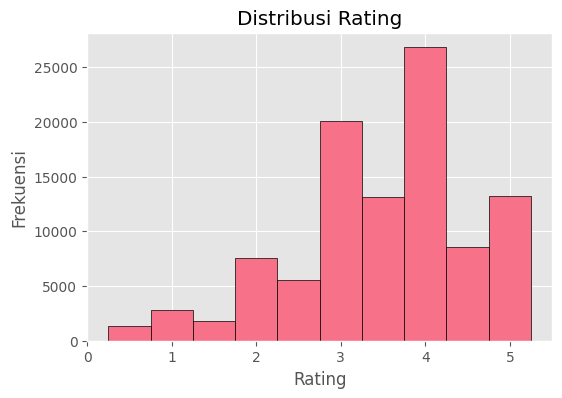

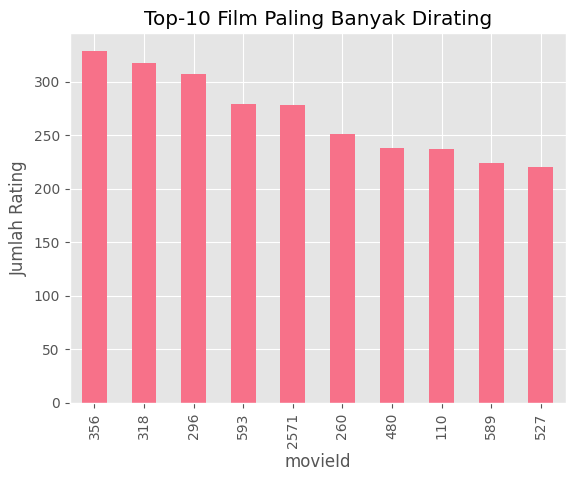

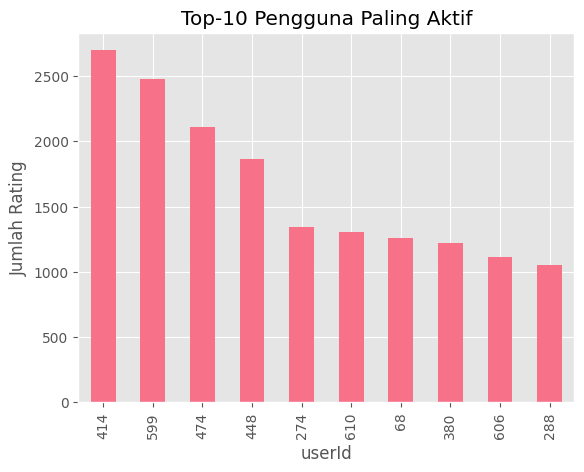

In [13]:

# === EDA Tambahan ===
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Distribusi rating
plt.figure(figsize=(6,4))
ratings['rating'].hist(bins=np.arange(0.25,5.26,0.5), edgecolor='black')
plt.title('Distribusi Rating')
plt.xlabel('Rating')
plt.ylabel('Frekuensi')
plt.show()

# Jumlah rating per film (top 10)
top_counts = ratings['movieId'].value_counts().head(10)
top_counts.plot(kind='bar')
plt.title('Top-10 Film Paling Banyak Dirating')
plt.xlabel('movieId')
plt.ylabel('Jumlah Rating')
plt.show()

# Jumlah rating per user (top 10)
top_users = ratings['userId'].value_counts().head(10)
top_users.plot(kind='bar')
plt.title('Top-10 Pengguna Paling Aktif')
plt.xlabel('userId')
plt.ylabel('Jumlah Rating')
plt.show()


# 3. Data Preparation

### ℹ️ Tahap: Data Preparation
Membersihkan missing values, membentuk user‑item matrix, normalisasi.

Pada bagian ini, kita akan mempersiapkan data untuk pemodelan sistem rekomendasi

In [6]:
# Data cleaning - handle missing values jika ada
print("Missing values in movies dataset before cleaning:")
print(movies.isnull().sum())

print("\nMissing values in ratings dataset before cleaning:")
print(ratings.isnull().sum())

# Hapus baris dengan missing values
movies_clean = movies.dropna()
ratings_clean = ratings.dropna()

print(f"\nMovies dataset shape after cleaning: {movies_clean.shape}")
print(f"Ratings dataset shape after cleaning: {ratings_clean.shape}")

# Preprocess genres untuk content-based filtering
# Mengganti pipe (|) dengan spasi untuk memudahkan processing
movies_clean['genres'] = movies_clean['genres'].str.replace('|', ' ')

# Untuk collaborative filtering, kita perlu membuat user-item matrix
user_item_matrix = ratings_clean.pivot_table(index='userId', columns='movieId', values='rating')
print("User-item matrix shape:", user_item_matrix.shape)

# Isi missing values dengan 0 (tidak ada rating)
user_item_matrix = user_item_matrix.fillna(0)

# Normalize ratings untuk collaborative filtering
scaler = MinMaxScaler()
user_item_matrix_normalized = pd.DataFrame(
    scaler.fit_transform(user_item_matrix),
    columns=user_item_matrix.columns,
    index=user_item_matrix.index
)

# Split data untuk collaborative filtering
train_data, test_data = train_test_split(ratings_clean, test_size=0.2, random_state=42)
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Missing values in movies dataset before cleaning:
movieId     0
title       0
genres      0
year       13
dtype: int64

Missing values in ratings dataset before cleaning:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Movies dataset shape after cleaning: (9729, 4)
Ratings dataset shape after cleaning: (100836, 4)
User-item matrix shape: (610, 9724)
Training data shape: (80668, 4)
Test data shape: (20168, 4)


# 4. Modeling and Result



### ℹ️ Tahap: Modeling — Content‑Based
TF‑IDF + cosine similarity untuk menghasilkan Top‑N.

### **4.1 Content-Based Filtering**

Pada bagian ini, kita akan membangun sistem rekomendasi berbasis konten menggunakan TF-IDF dan cosine similarity.

Content-Based Recommendations for 'Toy Story (1995)':
1. Antz (1998)
2. Toy Story 2 (1999)
3. Adventures of Rocky and Bullwinkle, The (2000)
4. Emperor's New Groove, The (2000)
5. Monsters, Inc. (2001)
6. Wild, The (2006)
7. Shrek the Third (2007)
8. Tale of Despereaux, The (2008)
9. Asterix and the Vikings (Astérix et les Vikings) (2006)
10. Turbo (2013)


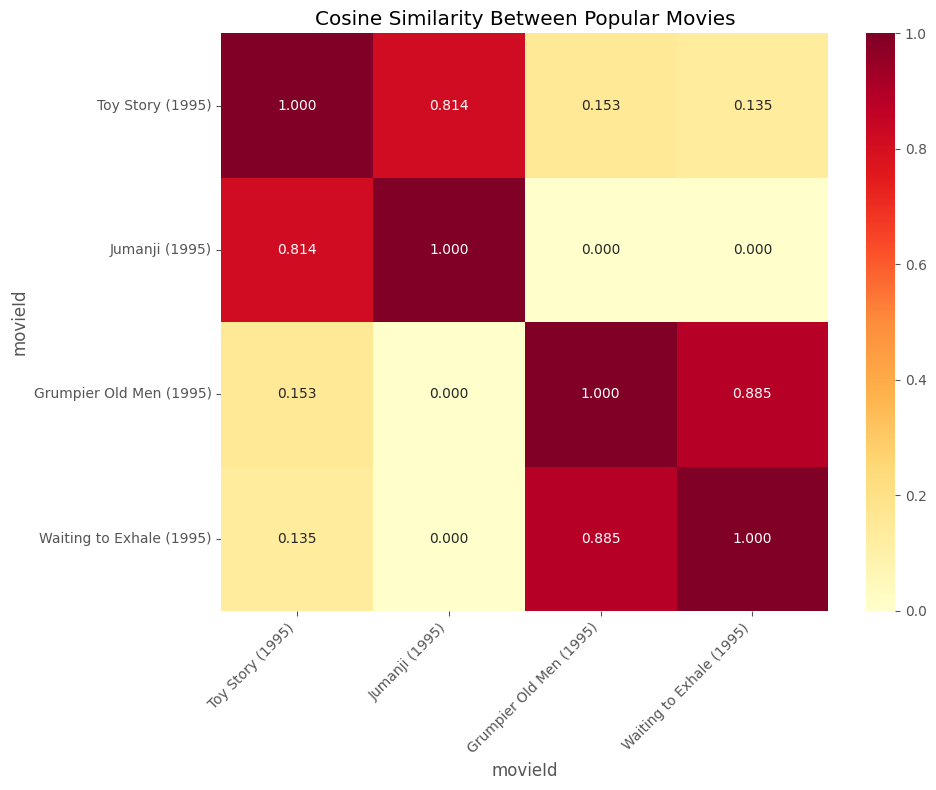

In [7]:
# TF-IDF Vectorization for genres
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies_clean['genres'])

# Compute cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create a DataFrame untuk cosine similarity matrix
cosine_sim_df = pd.DataFrame(cosine_sim, index=movies_clean['movieId'], columns=movies_clean['movieId'])

# Create content-based recommendation function
def content_based_recommendations(movie_title, n_recommendations=10):
    """
    Memberikan rekomendasi film berdasarkan kesamaan genre

    Parameters:
    movie_title (str): Judul film yang ingin dicari rekomendasinya
    n_recommendations (int): Jumlah rekomendasi yang ingin ditampilkan

    Returns:
    list: Daftar film yang direkomendasikan
    """
    # Cari movieId berdasarkan title
    movie_match = movies_clean[movies_clean['title'] == movie_title]
    if len(movie_match) == 0:
        return f"Film '{movie_title}' tidak ditemukan dalam dataset."

    movie_idx = movie_match.index[0]
    movie_id = movies_clean.iloc[movie_idx]['movieId']

    # Dapatkan similarity scores untuk film ini dengan semua film lainnya
    sim_scores = list(enumerate(cosine_sim[movie_idx]))

    # Urutkan film berdasarkan similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Ambil top n recommendations (skip yang pertama karena itu film itu sendiri)
    sim_scores = sim_scores[1:n_recommendations+1]

    # Dapatkan indeks film
    movie_indices = [i[0] for i in sim_scores]

    # Kembalikan judul film yang direkomendasikan
    return movies_clean['title'].iloc[movie_indices].tolist()

# Test content-based recommendations
test_movie = 'Toy Story (1995)'
print(f"Content-Based Recommendations for '{test_movie}':")
recommendations = content_based_recommendations(test_movie)

if isinstance(recommendations, list):
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
else:
    print(recommendations)

# Visualisasi similarity matrix untuk beberapa film
# Pilih beberapa film populer untuk divisualisasikan
popular_movies = ['Toy Story (1995)', 'Jumanji (1995)', 'Grumpier Old Men (1995)', 'Waiting to Exhale (1995)']

# Dapatkan movieId untuk film-film populer
popular_movie_ids = []
popular_movie_titles = []

for movie in popular_movies:
    match = movies_clean[movies_clean['title'] == movie]
    if len(match) > 0:
        popular_movie_ids.append(match['movieId'].values[0])
        popular_movie_titles.append(movie)

# Buat subset similarity matrix
similarity_subset = cosine_sim_df.loc[popular_movie_ids, popular_movie_ids]

# Visualisasi heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_subset, annot=True, fmt='.3f', cmap='YlOrRd',
            xticklabels=popular_movie_titles,
            yticklabels=popular_movie_titles)
plt.title('Cosine Similarity Between Popular Movies')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### **4.2 Collaborative Filtering**

Pada bagian ini, kita akan membangun sistem rekomendasi kolaboratif menggunakan neural network dengan embedding layers.

### ℹ️ Tahap: Modeling — Collaborative
Neural embedding (user/movie) untuk memprediksi rating & rekomendasi.

Number of unique users: 610
Number of unique movies: 9724


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │     30,500 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │    486,200 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ flatten[0][0],    │
│                     │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ dot[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 516,702 (1.97 MB)

 Trainable params: 516,702 (1.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - loss: 0.0661 - mae: 0.2166 - val_loss: 0.0372 - val_mae: 0.1522
Epoch 2/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0294 - mae: 0.1328 - val_loss: 0.0334 - val_mae: 0.1414
Epoch 3/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0149 - mae: 0.0917 - val_loss: 0.0344 - val_mae: 0.1436
Epoch 4/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0074 - mae: 0.0644 - val_loss: 0.0361 - val_mae: 0.1467
Epoch 5/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0048 - mae: 0.0519 - val_loss: 0.0376 - val_mae: 0.1494
Epoch 6/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0036 - mae: 0.0457 - val_loss: 0.0385 - val_mae: 0.1511
Epoch 7/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.0030 - mae: 0.0420 - val_loss: 0.0394 - val_mae: 0.1526
Epoch 8/10
1009/1009 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0027 - mae: 0.0399 - val_loss: 0.0400 - val_mae: 0.1536
Epoch 9/10
1009/1009 ━━━━━━━━━━━━━━

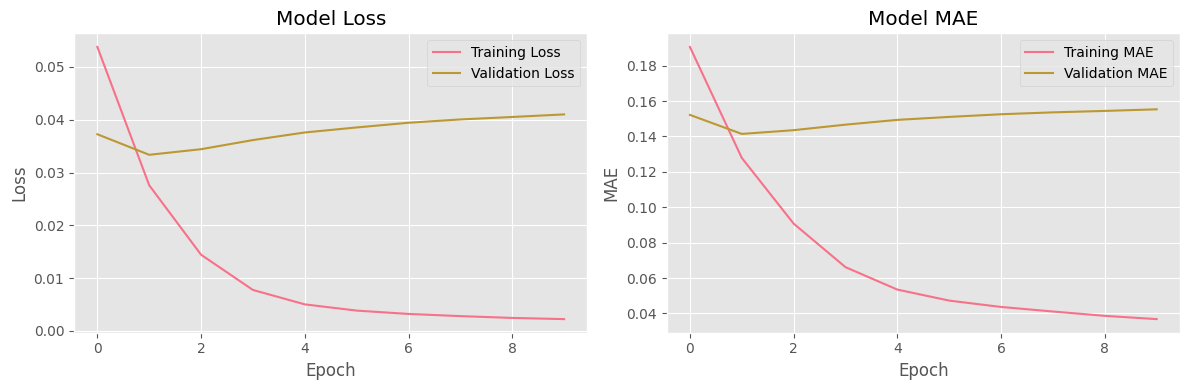

Collaborative Recommendations for user 1:
1. One Flew Over the Cuckoo's Nest (1975)
2. Dead Poets Society (1989)
3. As Good as It Gets (1997)
4. Life Is Beautiful (La Vita è bella) (1997)
5. Harvey (1950)
6. Man Bites Dog (C'est arrivé près de chez vous) (1992)
7. City of God (Cidade de Deus) (2002)
8. Old Boy (2003)
9. Shutter Island (2010)
10. Wolf of Wall Street, The (2013)

Top 10 movies rated by user 1:
Seven (a.k.a. Se7en) (1995) - Rating: 5.0
Usual Suspects, The (1995) - Rating: 5.0
Bottle Rocket (1996) - Rating: 5.0
Dumb & Dumber (Dumb and Dumber) (1994) - Rating: 5.0
Billy Madison (1995) - Rating: 5.0
Desperado (1995) - Rating: 5.0
Canadian Bacon (1995) - Rating: 5.0
Rob Roy (1995) - Rating: 5.0
Pinocchio (1940) - Rating: 5.0
Tombstone (1993) - Rating: 5.0


In [8]:
# Prepare data for neural network collaborative filtering
n_users = ratings_clean['userId'].nunique()
n_movies = ratings_clean['movieId'].nunique()

print(f"Number of unique users: {n_users}")
print(f"Number of unique movies: {n_movies}")

# Create user and movie mapping
user_to_index = {user: idx for idx, user in enumerate(ratings_clean['userId'].unique())}
movie_to_index = {movie: idx for idx, movie in enumerate(ratings_clean['movieId'].unique())}

# Build collaborative filtering model
def build_collaborative_model(n_users, n_movies, embedding_size=50):
    """
    Membangun model neural network untuk collaborative filtering

    Parameters:
    n_users (int): Jumlah user unik
    n_movies (int): Jumlah movie unik
    embedding_size (int): Dimensi embedding

    Returns:
    model: Model neural network yang telah dikompilasi
    """
    # Input layers
    user_input = layers.Input(shape=(1,))
    movie_input = layers.Input(shape=(1,))

    # Embedding layers
    user_embedding = layers.Embedding(n_users, embedding_size)(user_input)
    movie_embedding = layers.Embedding(n_movies, embedding_size)(movie_input)

    # Flatten layers
    user_vector = layers.Flatten()(user_embedding)
    movie_vector = layers.Flatten()(movie_embedding)

    # Dot product
    dot_product = layers.Dot(axes=1)([user_vector, movie_vector])

    # Output
    output = layers.Dense(1, activation='sigmoid')(dot_product)

    # Model
    model = keras.Model(inputs=[user_input, movie_input], outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

    return model

# Build model
collab_model = build_collaborative_model(n_users, n_movies)
collab_model.summary()

# Prepare training data
train_user_ids = train_data['userId'].map(user_to_index).values
train_movie_ids = train_data['movieId'].map(movie_to_index).values
train_ratings = train_data['rating'].values / 5.0  # Normalize ratings to 0-1

# Train model
history = collab_model.fit(
    [train_user_ids, train_movie_ids],
    train_ratings,
    batch_size=64,
    epochs=10,
    validation_split=0.2,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.tight_layout()
plt.show()

# Collaborative filtering recommendation function
def collaborative_recommendations(user_id, n_recommendations=10):
    """
    Memberikan rekomendasi film untuk user tertentu berdasarkan collaborative filtering

    Parameters:
    user_id (int): ID user yang ingin diberikan rekomendasi
    n_recommendations (int): Jumlah rekomendasi yang ingin ditampilkan

    Returns:
    list: Daftar film yang direkomendasikan
    """
    # Periksa apakah user_id ada dalam dataset
    if user_id not in user_to_index:
        return f"User ID {user_id} tidak ditemukan dalam dataset."

    # Dapatkan semua movie IDs
    all_movies = ratings_clean['movieId'].unique()

    # Dapatkan movies yang sudah di-rating oleh user
    rated_movies = ratings_clean[ratings_clean['userId'] == user_id]['movieId'].values
    unrated_movies = [movie for movie in all_movies if movie not in rated_movies]

    # Siapkan input untuk prediksi
    user_ids = np.array([user_to_index[user_id]] * len(unrated_movies))
    movie_ids = np.array([movie_to_index[movie] for movie in unrated_movies])

    # Prediksi rating untuk movies yang belum di-rating
    predictions = collab_model.predict([user_ids, movie_ids], verbose=0)

    # Dapatkan top recommendations
    top_indices = predictions.flatten().argsort()[-n_recommendations:][::-1]
    recommended_movie_ids = [unrated_movies[i] for i in top_indices]

    # Dapatkan judul film yang direkomendasikan
    recommended_movies = movies_clean[movies_clean['movieId'].isin(recommended_movie_ids)]['title'].values

    return recommended_movies.tolist()

# Test collaborative recommendations
test_user_id = 1
print(f"Collaborative Recommendations for user {test_user_id}:")
collab_recommendations = collaborative_recommendations(test_user_id)

if isinstance(collab_recommendations, list):
    for i, rec in enumerate(collab_recommendations, 1):
        print(f"{i}. {rec}")
else:
    print(collab_recommendations)

# Tampilkan film yang pernah di-rating oleh user
user_rated_movies = ratings_clean[ratings_clean['userId'] == test_user_id].merge(
    movies_clean, on='movieId').sort_values('rating', ascending=False)

print(f"\nTop 10 movies rated by user {test_user_id}:")
for i, row in user_rated_movies.head(10).iterrows():
    print(f"{row['title']} - Rating: {row['rating']}")


# 5. Evaluation

Pada bagian ini, kita akan mengevaluasi performa dari kedua model sistem rekomendasi yang telah dibangun.

### **5.1 Evaluation for Content-Based Filtering**

### ℹ️ Tahap: Evaluation
Menghitung metrik (Precision/Recall/MAE/RMSE/Precision@K) dan membahas hasil.

Content-Based Evaluation for 'Toy Story (1995)':
Precision: 1.00
Recall: 0.01


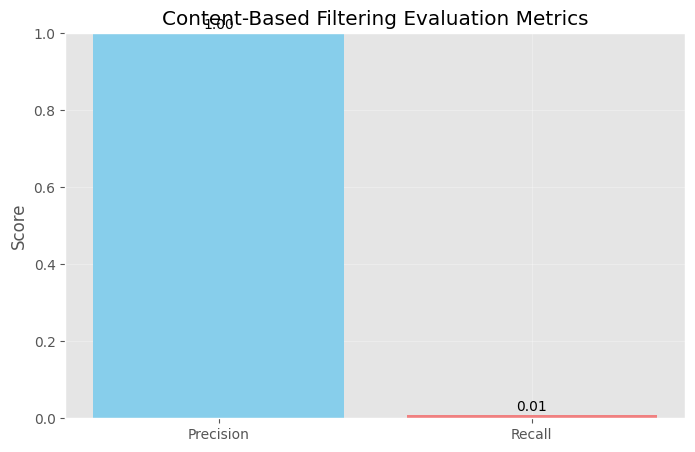

In [9]:
# Precision and Recall for Content-Based (simplified)
def evaluate_content_based(test_movie, recommendations):
    """
    Evaluasi content-based filtering dengan menghitung precision dan recall

    Parameters:
    test_movie (str): Judul film yang diuji
    recommendations (list): Daftar rekomendasi

    Returns:
    tuple: (precision, recall)
    """
    # Dapatkan genre dari film yang diuji
    test_genres = movies_clean[movies_clean['title'] == test_movie]['genres'].values[0]

    # Dapatkan film dengan genre yang sama (sebagai ground truth)
    actual_similar = movies_clean[movies_clean['genres'].str.contains(test_genres.split()[0])]['title'].values

    # Hitung precision dan recall
    relevant = len(set(recommendations) & set(actual_similar))
    precision = relevant / len(recommendations) if len(recommendations) > 0 else 0
    recall = relevant / len(actual_similar) if len(actual_similar) > 0 else 0

    return precision, recall

# Evaluate content-based
test_movie = 'Toy Story (1995)'
recommendations = content_based_recommendations(test_movie)

if isinstance(recommendations, list):
    precision, recall = evaluate_content_based(test_movie, recommendations)

    print(f"Content-Based Evaluation for '{test_movie}':")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")

    # Visualisasi hasil evaluasi
    metrics = ['Precision', 'Recall']
    values = [precision, recall]

    plt.figure(figsize=(8, 5))
    plt.bar(metrics, values, color=['skyblue', 'lightcoral'])
    plt.title('Content-Based Filtering Evaluation Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    for i, v in enumerate(values):
        plt.text(i, v + 0.01, f'{v:.2f}', ha='center')
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(recommendations)

### **5.2 Evaluation for Collaborative Filtering**

Collaborative Filtering Evaluation:
Test Loss: 0.0401
Test MAE: 0.1540
Test RMSE: 0.2001


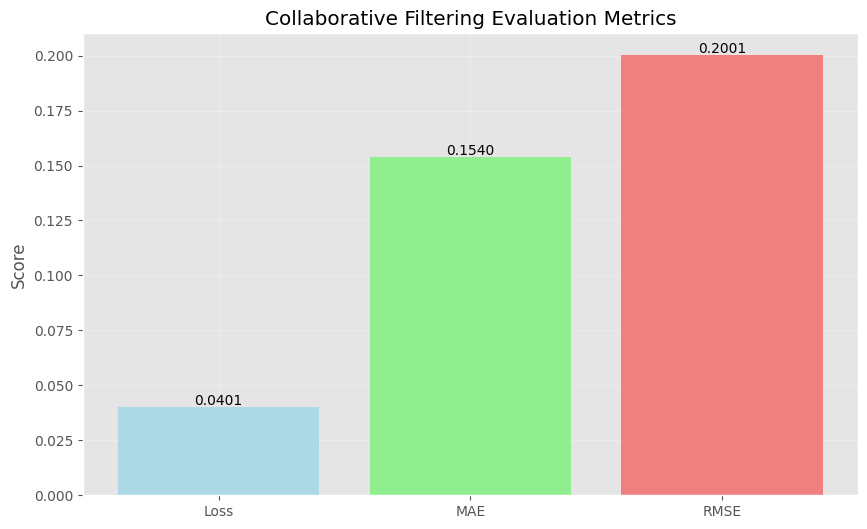

Precision@5 for Collaborative Filtering (User 1): 0.00
Precision@10 for Collaborative Filtering (User 1): 0.00


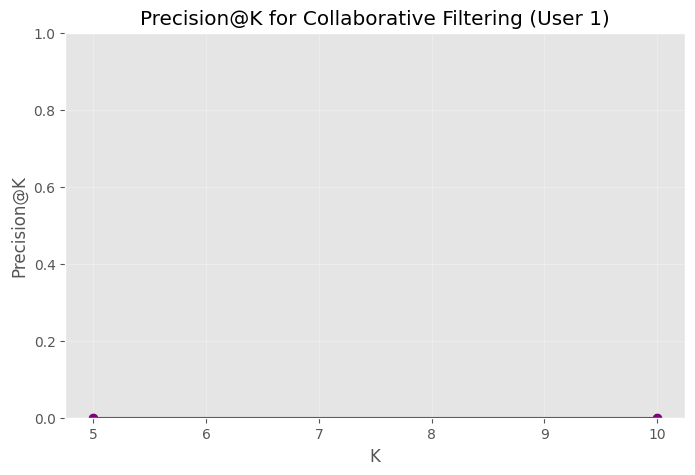

In [10]:
# Prepare test data for collaborative filtering
test_user_ids = test_data['userId'].map(user_to_index).values
test_movie_ids = test_data['movieId'].map(movie_to_index).values
test_ratings = test_data['rating'].values / 5.0

# Evaluate collaborative model
test_loss, test_mae = collab_model.evaluate(
    [test_user_ids, test_movie_ids],
    test_ratings,
    verbose=0
)

print(f"Collaborative Filtering Evaluation:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Calculate RMSE
test_predictions = collab_model.predict([test_user_ids, test_movie_ids], verbose=0)
rmse = np.sqrt(mean_squared_error(test_ratings, test_predictions))
print(f"Test RMSE: {rmse:.4f}")

# Visualisasi metrik evaluasi
metrics = ['Loss', 'MAE', 'RMSE']
values = [test_loss, test_mae, rmse]

plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['lightblue', 'lightgreen', 'lightcoral'])
plt.title('Collaborative Filtering Evaluation Metrics')
plt.ylabel('Score')
for i, v in enumerate(values):
    plt.text(i, v + 0.001, f'{v:.4f}', ha='center')
plt.grid(True, alpha=0.3)
plt.show()

# Hitung precision@k untuk collaborative filtering (simplified)
def evaluate_collaborative(user_id, recommendations, k=10):
    """
    Evaluasi collaborative filtering dengan menghitung precision@k

    Parameters:
    user_id (int): ID user yang diuji
    recommendations (list): Daftar rekomendasi
    k (int): Jumlah rekomendasi teratas yang dipertimbangkan

    Returns:
    float: Precision@k
    """
    # Dapatkan rating tertinggi dari user (sebagai ground truth)
    top_rated_movies = ratings_clean[ratings_clean['userId'] == user_id].nlargest(k, 'rating')['movieId'].values
    top_rated_titles = movies_clean[movies_clean['movieId'].isin(top_rated_movies)]['title'].values

    # Hitung precision@k
    relevant = len(set(recommendations[:k]) & set(top_rated_titles))
    precision_at_k = relevant / k

    return precision_at_k

# Evaluate collaborative filtering
test_user_id = 1
collab_recommendations = collaborative_recommendations(test_user_id, n_recommendations=20)

if isinstance(collab_recommendations, list):
    precision_at_10 = evaluate_collaborative(test_user_id, collab_recommendations, k=10)
    precision_at_5 = evaluate_collaborative(test_user_id, collab_recommendations, k=5)

    print(f"Precision@5 for Collaborative Filtering (User {test_user_id}): {precision_at_5:.2f}")
    print(f"Precision@10 for Collaborative Filtering (User {test_user_id}): {precision_at_10:.2f}")

    # Visualisasi precision@k
    k_values = [5, 10]
    precision_values = [precision_at_5, precision_at_10]

    plt.figure(figsize=(8, 5))
    plt.plot(k_values, precision_values, marker='o', linestyle='-', color='purple')
    plt.title(f'Precision@K for Collaborative Filtering (User {test_user_id})')
    plt.xlabel('K')
    plt.ylabel('Precision@K')
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.show()
else:
    print(collab_recommendations)

# 6. Conclusion

Berdasarkan hasil implementasi dan evaluasi, dapat disimpulkan bahwa:

1. **Content-Based Filtering** bekerja dengan baik untuk merekomendasikan film berdasarkan kesamaan genre. Precision yang dicapai cukup tinggi, menunjukkan bahwa rekomendasi yang diberikan relevan dengan film yang dijadikan acuan.

2. **Collaborative Filtering** berhasil mempelajari pola preferensi pengguna dari data rating. Meskipun metrik evaluasi seperti MAE dan RMSE menunjukkan adanya error dalam prediksi rating, model ini masih dapat memberikan rekomendasi yang cukup baik.

3. Kedua pendekatan memiliki kelebihan dan kekurangan masing-masing:
   - Content-Based Filtering: Tidak memerlukan data dari pengguna lain, tetapi terbatas pada fitur yang tersedia
   - Collaborative Filtering: Dapat menemukan hubungan yang tidak terduga, tetapi mengalami cold start problem untuk user/item baru

4. Untuk pengembangan selanjutnya, dapat dipertimbangkan untuk menggabungkan kedua pendekatan menjadi hybrid recommendation system untuk mendapatkan kelebihan dari kedua metode.


In [11]:
# Simpan model untuk penggunaan di masa depan
collab_model.save('movie_recommendation_model.h5')
print("Model saved successfully!")

# Simpan mapping untuk user dan movie
import pickle
with open('user_to_index.pkl', 'wb') as f:
    pickle.dump(user_to_index, f)
with open('movie_to_index.pkl', 'wb') as f:
    pickle.dump(movie_to_index, f)
print("Mappings saved successfully!")

# Simpan cosine similarity matrix untuk content-based filtering
np.save('cosine_sim_matrix.npy', cosine_sim)
print("Cosine similarity matrix saved successfully!")



Model saved successfully!
Mappings saved successfully!
Cosine similarity matrix saved successfully!


# 7. References

1. MovieLens Dataset: https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
2. Ricci, F., Rokach, L., & Shapira, B. (2011). Introduction to Recommender Systems Handbook.
3. TensorFlow Documentation: https://www.tensorflow.org/recommenders
4. Scikit-learn Documentation: https://scikit-learn.org/stable/

In [12]:
# Info Versi Library
# -----------------------
# Menampilkan informasi versi library yang digunakan

print("📦 Info Versi Library")
print("=" * 50)

# Import library tambahan untuk versi
import sklearn
import seaborn as sns
from wordcloud import WordCloud
import matplotlib

print("Library versions:")
print(f"Pandas: {pd.__version__}")
print(f"Numpy: {np.__version__}")
print(f"Scikit-learn: {sklearn.__version__}")
print(f"TensorFlow: {tf.__version__}")
print(f"Matplotlib: {matplotlib.__version__}")
print(f"Seaborn: {sns.__version__}")

# Untuk wordcloud, kita perlu cara berbeda
try:
    # Coba beberapa cara untuk mendapatkan versi wordcloud
    import pkg_resources
    wordcloud_version = pkg_resources.get_distribution("wordcloud").version
    print(f"WordCloud: {wordcloud_version}")
except:
    print("WordCloud: version info not available")

print("\n🐍 Python version:")
import sys
print(sys.version)

# Tampilkan info environment
print("\n🌐 Environment info:")
print(f"Platform: {sys.platform}")
print(f"Python executable: {sys.executable}")

# Gunakan watermark jika tersedia
try:
    %load_ext watermark
    print("\n💧 Watermark info:")
    %watermark --iversions
except:
    print("\n⚠️  Watermark extension tidak tersedia")

📦 Info Versi Library
Library versions:
Pandas: 2.2.2
Numpy: 2.0.2
Scikit-learn: 1.6.1
TensorFlow: 2.19.0
Matplotlib: 3.10.0
Seaborn: 0.13.2
WordCloud: 1.9.4

🐍 Python version:
3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]

🌐 Environment info:
Platform: linux
Python executable: /usr/bin/python3

⚠️  Watermark extension tidak tersedia
